- This notebook documents an iterative development process aimed at building a robust PDF question-answering system. Multiple approaches were explored to identify and address performance bottlenecks.

# Key challenges discussed -
1. Scanned vs. digitally generated PDFs: Extracting content from scanned PDFs using OCR ( Tesseract) / unstructered required different handling compared to structurally tagged, downloadable PDFs.

2. Image and chart understanding: Detecting and interpreting visual elements—particularly graphs and charts—demanded additional engineering, including trend line analysis and image captioning, to improve reliability and reduce model hallucinations.

In [ ]:
!pip install langchain_groq --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
!pip install "unstructured[all-docs]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.9/527.9 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.6 MB/s eta 0:00:00
   ━

In [ ]:
from __future__ import annotations

import os
import uuid
import base64
from io import BytesIO
from pathlib import Path

from PIL import Image
from unstructured.partition.pdf import partition_pdf
from transformers import pipeline

In [ ]:
!pip install -U langchain langchain-community transformers accelerate sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 4.1.0
    Uninstalling sentence-transformers-4.1.0:
      Successfully uninstalled sentence-transformers-4.1.0


In [ ]:
!pip install -U langchain-groq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

# Pls note I am hiding my API keys - pls replace with your own when running the notebook

In [ ]:
import os

os.environ["GROQ_API_KEY"] = "XXX"
os.environ["HUGGINGFACEHUB_API_TOKEN"] = "XXXX"


In [ ]:
assert os.getenv("GROQ_API_KEY"), "GROQ_API_KEY received "
assert os.getenv("HUGGINGFACEHUB_API_TOKEN"), "HUGGINGFACEHUB_API_TOKEN received"


In [ ]:
!apt-get install -y poppler-utils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (352 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
from pdf2image import convert_from_path
images = convert_from_path('/content/attention.pdf')

images[0].show()


In [ ]:
PDF_FILE = Path("/content/attention.pdf")

## Extracting tables and images

In [ ]:
chunks = partition_pdf(
    filename=str(PDF_FILE),
    infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10_000,
    combine_text_under_n_chars=2_000,
    new_after_n_chars=6_000,
)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
print(f"total chunks: {len(chunks)}")



total chunks: 2


In [ ]:
for i, chunk in enumerate(chunks[:5]):
    print(f"\n--- Chunk {i+1} ---")
    print(f"Type: {type(chunk)}")
    print(f"Text: {chunk.text[:500] if hasattr(chunk, 'text') else 'No text'}")


--- Chunk 1 ---
Type: <class 'unstructured.documents.elements.CompositeElement'>
Text: 3.1. Application: Competitor Networks

3.1.3 Explanatory Analysis

Upon the completion of the construction of the competitors network we pro- ceed by investigating the main characteristics of the network. The competi- tors network is a directed graph consisted of |V| = 2.327 nodes and |E| = 3.429 edges. Recall from Section 1.2 that for a directed graph the number of all possible links between its nodes is calculated as N · (N − 1) = 5.412.602. To be more precise the graph density D = 0.00063. We

--- Chunk 2 ---
Type: <class 'unstructured.documents.elements.CompositeElement'>
Text: Table 3.1: Top 10 rankings of diﬀerent importance measures. The companies with the highest centrality scores with respect to at least three diﬀerent metrics are highlighted in bold font style.

34


Issue - No image detected (table,text detected)


In [ ]:
from PIL import Image
import io

for i, chunk in enumerate(chunks):
    if hasattr(chunk, "metadata") and chunk.metadata.image_path:
        print(f"Found image in chunk {i}")
        image_bytes = chunk.metadata.image_path.read_bytes()
        image = Image.open(io.BytesIO(image_bytes))
        display(image)
        break


In [ ]:
extract_image_block_types=["Image"],
extract_image_block_to_payload=True


In [ ]:
for i, chunk in enumerate(chunks):
    if hasattr(chunk, "image") and chunk.image is not None:
        print(f"Chunk {i} contains an image.")


In [ ]:
for i, chunk in enumerate(chunks):
    print(f"Chunk {i}: {type(chunk)}")


Chunk 0: <class 'unstructured.documents.elements.CompositeElement'>
Chunk 1: <class 'unstructured.documents.elements.CompositeElement'>


In [ ]:
chunks = partition_pdf(
    filename=str(PDF_FILE),
    strategy="ocr_only",
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
)


In [ ]:
from unstructured.documents.elements import Image as UnstructuredImage
from PIL import Image
import io

for i, chunk in enumerate(chunks):
    if isinstance(chunk, UnstructuredImage):
        print(f"Image found at chunk {i}")
        image = Image.open(io.BytesIO(chunk.image.data))
        display(image)
        break


# What worked

In [ ]:

images = convert_from_path(str(PDF_FILE))
images[0].show()


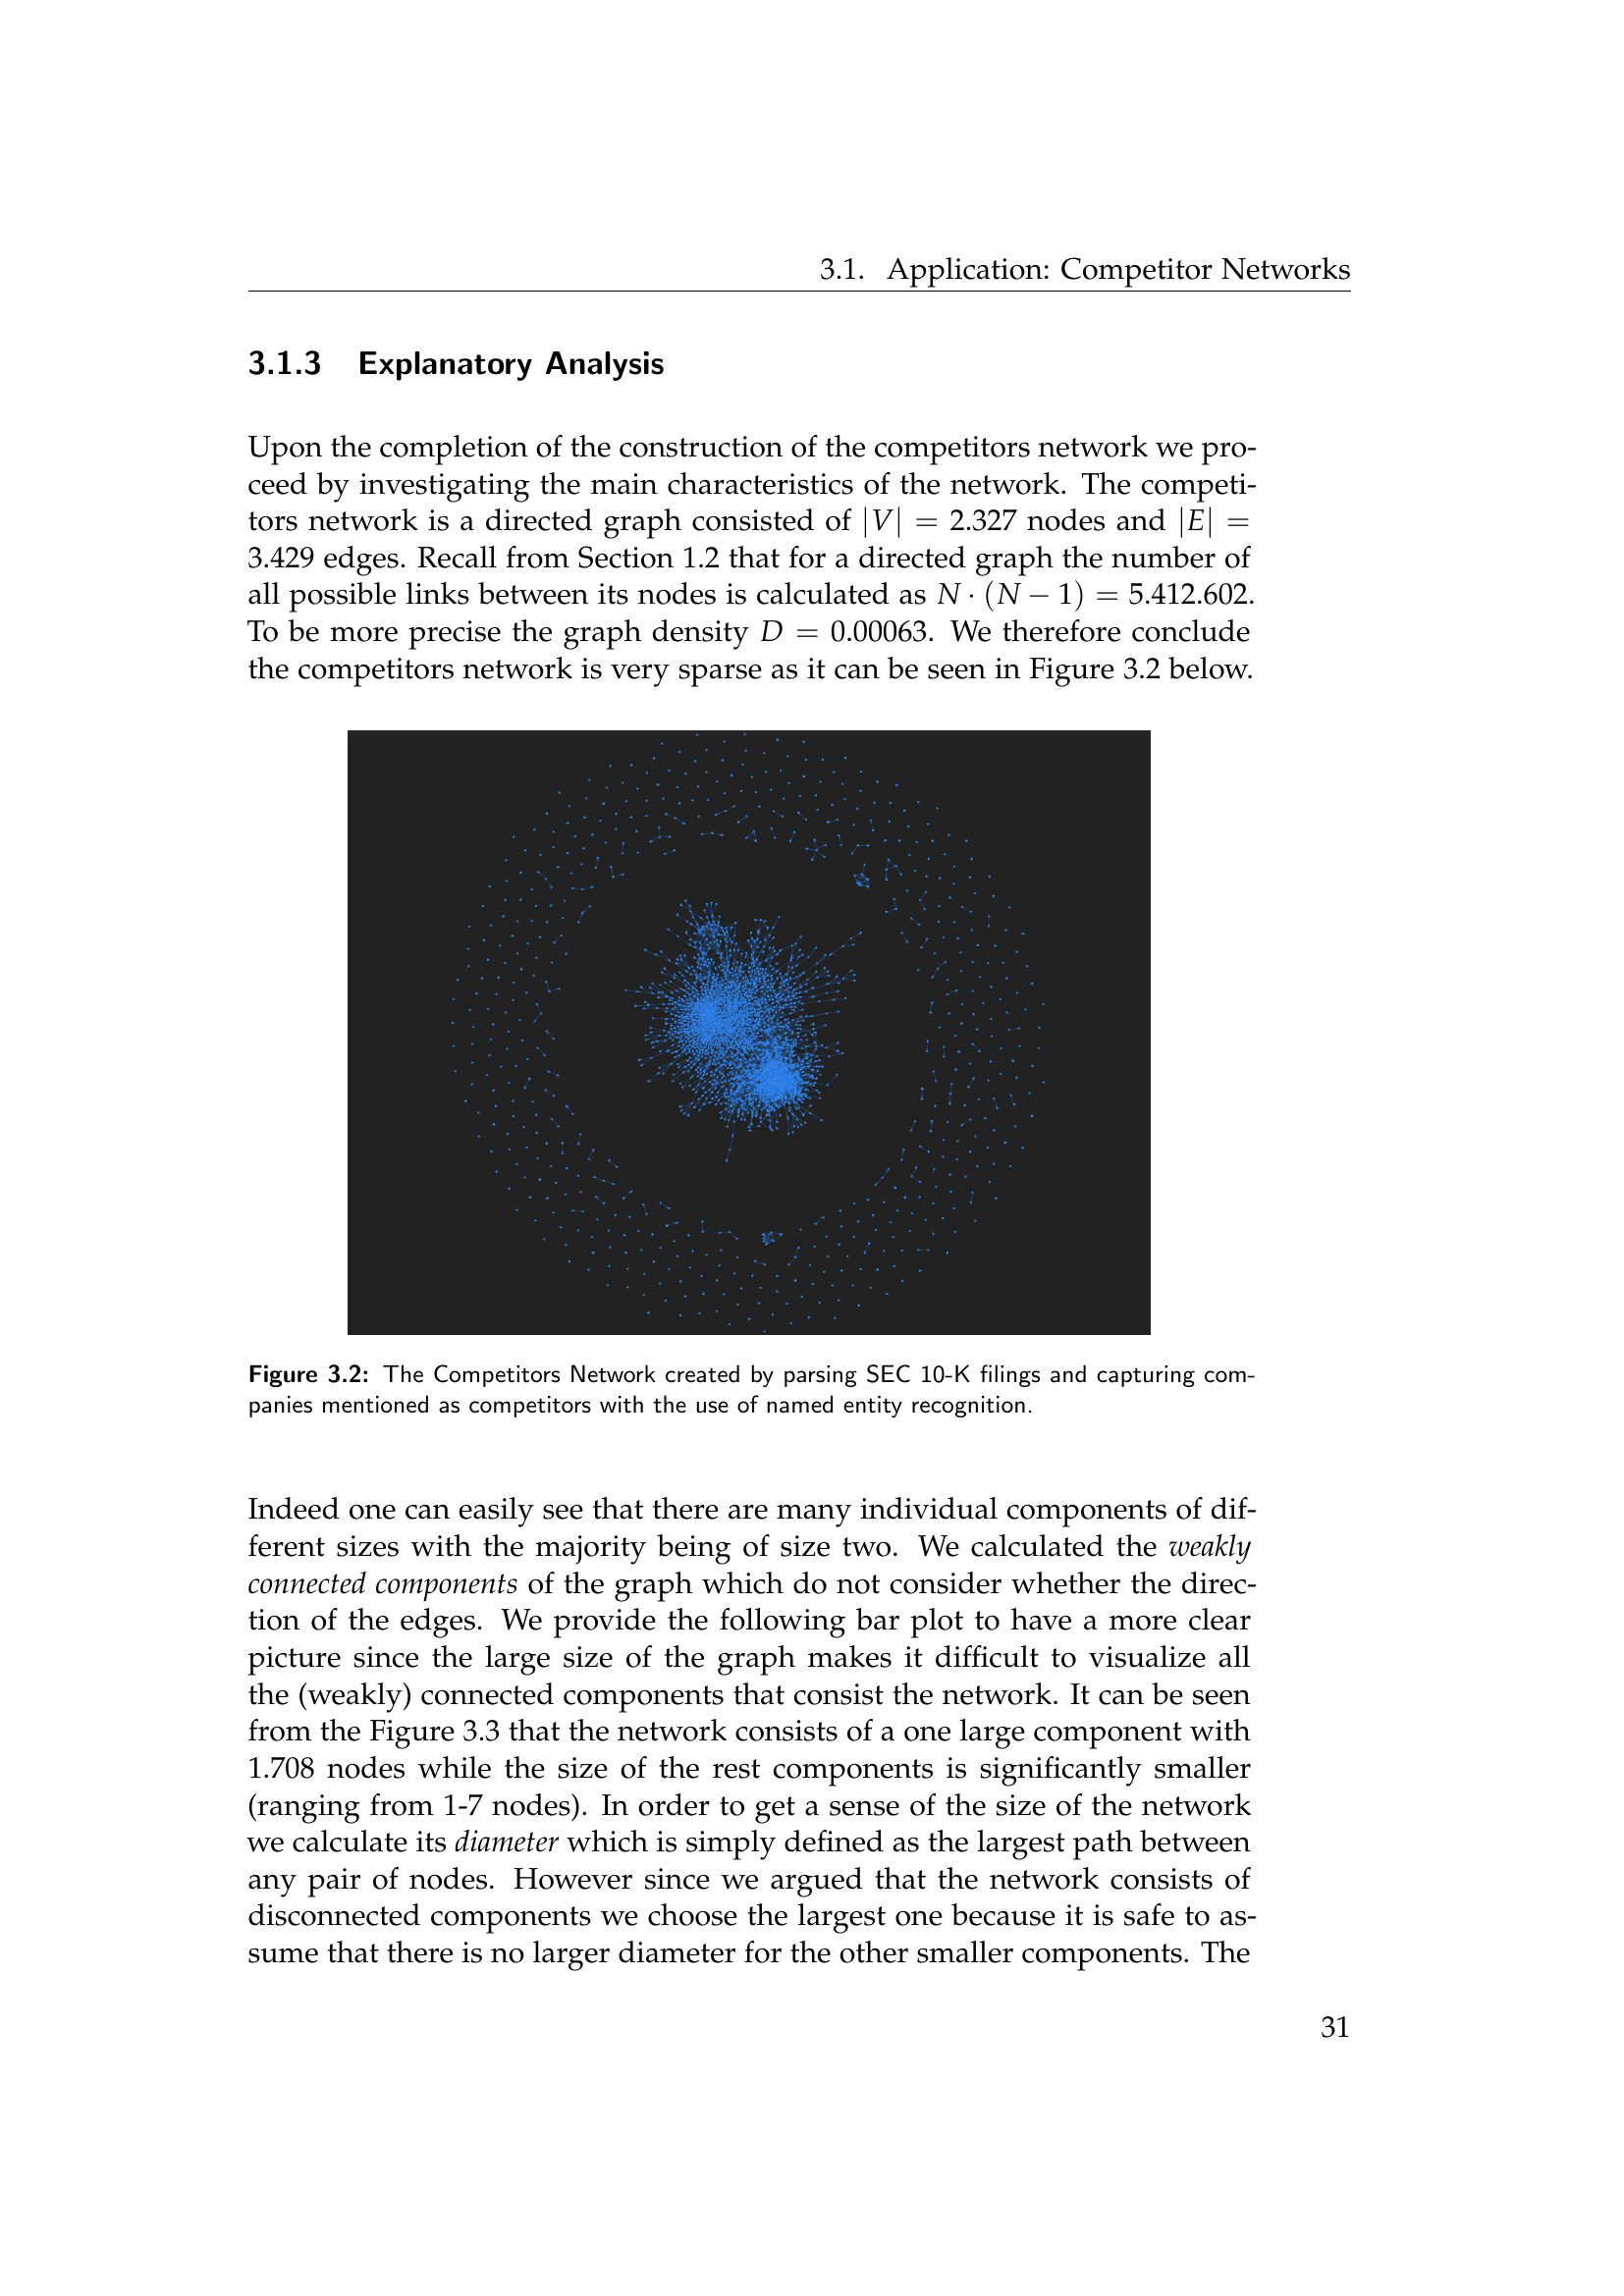

In [ ]:

display(images[0])


In [ ]:
!pip install pytesseract


pytesseract is a Python wrapper for Tesseract OCR, which means it takes in images (like PNG, JPEG, pages from pdf2image) And extracts text from those images using OCR (Optical Character Recognition)


In [ ]:
import pytesseract

text = pytesseract.image_to_string(images[0])
print(text)

3.1. Application: Competitor Networks

 

3.1.3. Explanatory Analysis

Upon the completion of the construction of the competitors network we pro-
ceed by investigating the main characteristics of the network. The competi-
tors network is a directed graph consisted of |V| = 2.327 nodes and |E| =
3.429 edges. Recall from Section 1.2 that for a directed graph the number of
all possible links between its nodes is calculated as N - (N — 1) = 5.412.602.
To be more precise the graph density D = 0.00063. We therefore conclude
the competitors network is very sparse as it can be seen in Figure 3.2 below.

 

Figure 3.2: The Competitors Network created by parsing SEC 10-K filings and capturing com-
panies mentioned as competitors with the use of named entity recognition.

Indeed one can easily see that there are many individual components of dif-
ferent sizes with the majority being of size two. We calculated the weakly
connected components of the graph which do not consider whether the direc-
ti

Understand this partition_pdf() struggled with OCR or layout
 pytesseract.image_to_string() gave you much better results because it's doing pure OCR on the full image of the page

# Comparing the 2 approaches

-  unstructered parses the documents and pytesseract (OCR wrapper) extracts text from images . Un structured uses strategies such as hi_res vs ocr_only and these have diff impacts on scanned vs downloaded PDFs

1. For downloaded PDF - hi_res performs better that text and table detection however struggles with image extraction -> this is where stragey ocr_only is helpful

2. For scanned pdf - hi_res performs extremely poorly on image, table and text detetcion

Therefore, later I will be using a combination of both so the LLM is compatible with both versions of PDFs

In [ ]:
chunks = partition_pdf(
    filename=str(PDF_FILE),
    strategy="ocr_only",  # force OCR of image-based PDFs
    infer_table_structure=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
)

In [ ]:
for i, chunk in enumerate(chunks):
    print(f"Chunk {i}: {type(chunk)}")

Chunk 0: <class 'unstructured.documents.elements.Title'>
Chunk 1: <class 'unstructured.documents.elements.Title'>
Chunk 2: <class 'unstructured.documents.elements.NarrativeText'>
Chunk 3: <class 'unstructured.documents.elements.NarrativeText'>
Chunk 4: <class 'unstructured.documents.elements.NarrativeText'>
Chunk 5: <class 'unstructured.documents.elements.Text'>
Chunk 6: <class 'unstructured.documents.elements.ListItem'>
Chunk 7: <class 'unstructured.documents.elements.Text'>
Chunk 8: <class 'unstructured.documents.elements.NarrativeText'>
Chunk 9: <class 'unstructured.documents.elements.Text'>
Chunk 10: <class 'unstructured.documents.elements.Text'>
Chunk 11: <class 'unstructured.documents.elements.Title'>
Chunk 12: <class 'unstructured.documents.elements.Text'>
Chunk 13: <class 'unstructured.documents.elements.Title'>
Chunk 14: <class 'unstructured.documents.elements.Title'>
Chunk 15: <class 'unstructured.documents.elements.NarrativeText'>
Chunk 16: <class 'unstructured.documents.ele

In [ ]:
for i, chunk in enumerate(chunks):
    if hasattr(chunk, "text"):
        print(f"\n--- Chunk {i} ({chunk.__class__.__name__}) ---")
        print(chunk.text[:300])



--- Chunk 0 (Title) ---
3.1. Application: Competitor Networks

--- Chunk 1 (Title) ---
3.1.3. Explanatory Analysis

--- Chunk 2 (NarrativeText) ---
Upon the completion of the construction of the competitors network we pro- ceed by investigating the main characteristics of the network. The competi- tors network is a directed graph consisted of |V| = 2.327 nodes and |E| = 3.429 edges. Recall from Section 1.2 that for a directed graph the number o

--- Chunk 3 (NarrativeText) ---
Figure 3.2: The Competitors Network created by parsing SEC 10-K filings and capturing com- panies mentioned as competitors with the use of named entity recognition.

--- Chunk 4 (NarrativeText) ---
Indeed one can easily see that there are many individual components of dif- ferent sizes with the majority being of size two. We calculated the weakly connected components of the graph which do not consider whether the direc- tion of the edges. We provide the following bar plot to have a more clear 

--- Chunk 5 (Text

- There is a difference between PDFs files which need to be dealth different. For first test i will just be downloading and seeing if table can be detected fom partion.
- One more thing about OCR is that it distorts numerical data in tables

# Optimising Table Detection

In [ ]:
from unstructured.partition.pdf import partition_pdf
from pathlib import Path

PDF_FILE = Path("/content/sample-tables.pdf")

chunks = partition_pdf(
    filename=str(PDF_FILE),
    strategy="hi_res",
    infer_table_structure=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    include_page_breaks=False,
    pages=[0]
)


In [ ]:
for i, chunk in enumerate(chunks):
    print(f"\n--- Chunk {i} ---")
    print(f"Type: {type(chunk)}")
    if hasattr(chunk, "text"):
        print(chunk.text[:500])



--- Chunk 0 ---
Type: <class 'unstructured.documents.elements.Title'>
Design and build accessible PDF tables Sample tables

--- Chunk 1 ---
Type: <class 'unstructured.documents.elements.Text'>
Table 1

--- Chunk 2 ---
Type: <class 'unstructured.documents.elements.Table'>
Column header (TH) Column header (TH) Column header (TH) Row header (TH) Data cell (TD) Data cell (TD) Row header(TH) Data cell (TD) Data cell (TD)

--- Chunk 3 ---
Type: <class 'unstructured.documents.elements.Title'>
Table 2: example of footnotes referenced from within a table

--- Chunk 4 ---
Type: <class 'unstructured.documents.elements.Table'>
Expenditure by function £ million 2009/10 2010/11 1 Policy functions Financial 22.5 30.57 Information 2 10.2 14.8 Contingency 2.6 1.2 Remunerated functions Agency services 3 44.7 35.91 Payments 22.41 19.88 Banking 22.90 44.23 Other 12.69 10.32

--- Chunk 5 ---
Type: <class 'unstructured.documents.elements.ListItem'>
(1) Provisional total as of publication date.

--- Chunk 6

In [ ]:
from unstructured.documents.elements import Table

tables = [chunk for chunk in chunks if isinstance(chunk, Table)]

if tables:
    print(f"\n found {len(tables)} table on the first page:")
    for i, table in enumerate(tables):
        print(f"\n Table {i} \n{table.text[:500]}")
else:
    print("\n no tables found on this page.")


 found 30 table on the first page:

 Table 0 
Column header (TH) Column header (TH) Column header (TH) Row header (TH) Data cell (TD) Data cell (TD) Row header(TH) Data cell (TD) Data cell (TD)

 Table 1 
Expenditure by function £ million 2009/10 2010/11 1 Policy functions Financial 22.5 30.57 Information 2 10.2 14.8 Contingency 2.6 1.2 Remunerated functions Agency services 3 44.7 35.91 Payments 22.41 19.88 Banking 22.90 44.23 Other 12.69 10.32

 Table 2 
Main character Daniel Radcliffe Sidekick 1 Rupert Grint Sidekick 2 Emma Watson Lovable ogre Robbie Coltrane Professor Maggie Smith Headmaster Richard Harris

 Table 3 
Role Actor Main character Daniel Radcliffe Sidekick 1 Rupert Grint Sidekick 2 Emma Watson Lovable ogre Robbie Coltrane Professor Maggie Smith Headmaster Richard Harris

 Table 4 
2010 2009 Non-current assets Property 345 445 Investment 567 654 Intangibles 423 123 Current assets Trade and other receivables 435 634 Cash and cash equivalents 524 123 Other 223 211 2008 222

Great all tables detected

LLaMA 3.1 from Groq to generate summaries.

In [ ]:
text_chunks = [c.text for c in chunks if hasattr(c, "text") and not isinstance(c, Table)]
table_chunks = [c for c in chunks if isinstance(c, Table)]


In [ ]:
print(f"Text chunks: {len(text_chunks)}")
print(f"Table chunks: {len(table_chunks)}")

Text chunks: 57
Table chunks: 30


In [ ]:
text_table_prompt = ChatPromptTemplate.from_template(
    """
You are an assistant tasked with summarising tables or text.
Provide a concise, standalone summary.
Respond only with the summary — no headings, no introductions.

Table/text chunk:
{element}
"""
)

In [ ]:
groq_model = ChatGroq(model="llama-3.1-8b-instant", temperature=0.4)
summary_chain = {"element": lambda x: x} | text_table_prompt | groq_model | StrOutputParser()


In [ ]:
!pip install langchain_core --quiet

# Rate Limit Handling in LangChain Summarization Pipeline



In [ ]:
import time
from langchain_core.exceptions import RateLimitError

def safe_summary(chunk):
    while True:
        try:
            return summary_chain.invoke(chunk)
        except RateLimitError:
            print("Rate limit hit. Waiting...")
            time.sleep(3)

text_summaries = [safe_summary(c) for c in text_chunks]


ImportError: cannot import name 'RateLimitError' from 'langchain_core.exceptions' (/usr/local/lib/python3.11/dist-packages/langchain_core/exceptions.py)

Because I m on the free tier ;-;; so the code below does it till the limit, stores it until I run out of rate limit :)

# How to fix the rate limit error and optimally use the API limits

- Everytime a rate limit error is raise - > sleep for 3 seconds and send another request.
- Loop over all the chunks with a 1.5 second delay to prevent hitting the limit.


In [ ]:
import time

text_summaries = []

for i, chunk in enumerate(text_chunks):
    try:
        summary = summary_chain.invoke(chunk)
        text_summaries.append(summary)
        print(f"Processed chunk {i+1}/{len(text_chunks)}")
        time.sleep(1.5)  # I just put this delay to stay safe
    except Exception as e:
        print(f"Stopped at chunk {i+1}: {str(e)}")
        if "rate limit" in str(e).lower():
            break


Processed chunk 1/57
Processed chunk 2/57
Processed chunk 3/57
Processed chunk 4/57
Processed chunk 5/57
Processed chunk 6/57
Processed chunk 7/57
Processed chunk 8/57
Processed chunk 9/57
Processed chunk 10/57
Processed chunk 11/57
Processed chunk 12/57
Processed chunk 13/57
Processed chunk 14/57
Processed chunk 15/57
Processed chunk 16/57
Processed chunk 17/57
Processed chunk 18/57
Processed chunk 19/57
Processed chunk 20/57
Processed chunk 21/57
Processed chunk 22/57
Processed chunk 23/57
Processed chunk 24/57
Processed chunk 25/57
Processed chunk 26/57
Processed chunk 27/57
Processed chunk 28/57
Processed chunk 29/57
Processed chunk 30/57
Processed chunk 31/57
Processed chunk 32/57
Processed chunk 33/57
Processed chunk 34/57
Processed chunk 35/57
Processed chunk 36/57
Processed chunk 37/57
Processed chunk 38/57
Processed chunk 39/57
Processed chunk 40/57
Processed chunk 41/57
Processed chunk 42/57
Processed chunk 43/57
Processed chunk 44/57
Processed chunk 45/57
Processed chunk 46/

In [ ]:
table_html = [t.metadata.text_as_html for t in table_chunks]
table_summaries = []

In [ ]:
for i, chunk in enumerate(table_html):
    try:
        summary = summary_chain.invoke(chunk)
        table_summaries.append(summary)
        print(f"processed table {i+1}/{len(table_html)}")
        time.sleep(1.5)
    except Exception as e:
        print(f"stopped at table {i+1}: {str(e)}")
        if "rate limit" in str(e).lower():
            break

processed table 1/30
processed table 2/30
processed table 3/30
processed table 4/30
processed table 5/30
processed table 6/30
processed table 7/30
processed table 8/30
processed table 9/30
processed table 10/30
processed table 11/30
processed table 12/30
processed table 13/30
processed table 14/30
processed table 15/30
processed table 16/30
processed table 17/30
processed table 18/30
processed table 19/30
processed table 20/30
processed table 21/30
processed table 22/30
processed table 23/30
processed table 24/30
processed table 25/30
processed table 26/30
processed table 27/30
processed table 28/30
processed table 29/30
processed table 30/30


# Approach 1 - Using the Table summaries for GROQ

- Pro: it reduces storage and speeds up retrieval, as fewer tokens are stored in the vector database  FAISS. Summarizing tables before embedding results in smaller, more efficient chunks.

- Con: risks omitting critical details that may be essential for accurate question answering. This issue is especially significant when using smaller language models, which are more prone to hallucination or generating incorrect responses when the context lacks precision.

In [ ]:
for i, s in enumerate(text_summaries):
    print(f"\n Text Summary {i+1}:\n{s}")


 Text Summary 1:
To create accessible PDF tables, use a clear and simple design, include a header row, and use column headers that describe the data. Use table headers, footers, and summaries to provide context, and ensure sufficient color contrast between text and background.

 Text Summary 2:
No information provided about Table 1.

 Text Summary 3:
This table demonstrates how footnotes can be referenced within a table, providing additional information or explanations for specific data points.

 Text Summary 4:
Current data as of the publication date is preliminary.

 Text Summary 5:
The on-going costs associated with information programmes include personnel, equipment, software, maintenance, training, and updates.

 Text Summary 6:
This is a financial statement line item representing the total debt or liability, excluding any recoveries and interest charges.

 Text Summary 7:
The table lists film credits with the following columns: 'Film Title', 'Director', 'Year', 'Genre', 'Rating'

In [ ]:
for i, s in enumerate(table_summaries):
    print(f"\n Table Summary {i+1}:\n{s}")


 Table Summary 1:
A table with 4 columns and 2 rows contains data with headers, including "Column", "header (TH)", "Column header (TH)", and "Column header (TH)" with data in each cell.

 Table Summary 2:
Expenditure increased from 2009/10 to 2010/11, with policy functions rising by 36% (£8.33m) and remunerated functions decreasing by 20% (£8.8m).

 Table Summary 3:
The main character, DanxlRadclffe, has a sidekick (Rupert Grint and Emma Watson), a lovable character (Robb Coltrane), a professor (Maggz Sm ith), and a headmaster (Richard Harris).

 Table Summary 4:
DanxlRadclffe is the main character, accompanied by sidekicks Rupert Grint and Emma Watson, a lovable ogre played by Robb Coltrane, a Professor played by Maggz Smith, and a Headmaster played by Richard Harris.

 Table Summary 5:
Non-current assets increased from 1235 in 2008 to 1335 in 2009, then decreased to 1335 in 2010. Current assets decreased from 1192 in 2008 to 572 in 2009, then increased to 1182 in 2010.

 Table Summa

In [ ]:
import json

with open("summaries_text.json", "w") as f:
    json.dump(text_summaries, f, indent=2)

with open("summaries_tables.json", "w") as f:
    json.dump(table_summaries, f, indent=2)


# Embed and store summaries to vector database – FAISS

In [ ]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 11.6 MB/s eta 0:00:00


In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_core.documents import Document
docs = [Document(page_content=s, metadata={"source": f"Chunk {i}"}) for i, s in enumerate(text_summaries)]
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db = FAISS.from_documents(docs, embedding_model)

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

groq_llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0.4)

prompt = ChatPromptTemplate.from_template("""
You are an assistant helping a student understand content from a research paper.
Answer the user's question using only the context below.

Context:
{context}

User's Question:
{question}

Answer (keep it clear and concise):
""")

qa_chain = prompt | groq_llm | StrOutputParser()


### vector similarity search in  FAISS to find the top 3 most relevant documents to the user's query.

In [ ]:
while True:
    query = input("👤 You: ")
    if query.lower() in ["exit", "quit"]:
        break
    docs = db.similarity_search(query, k=3)
    context = "\n\n".join([doc.page_content for doc in docs])
    answer = qa_chain.invoke({"context": context, "question": query})
    print(f"🤖 GroqBot:\n{answer}\n")


👤 You: Hello
🤖 GroqBot:
Hello. How can I assist you with the bad debt provision from the 2011 data?

👤 You: what is the document about
🤖 GroqBot:
The document appears to be about creating accessible PDF tables, specifically providing guidelines and recommendations for designing and formatting tables to make them easier to understand and use for readers.

👤 You: from table 20 can u tell me how much the policy functions earned in 2009/10
🤖 GroqBot:
There is no information provided about Table 20, nor any previous tables (Table 1, Table 18, or any other tables). The context only provides financial data for a single year, but it does not mention Table 20 or any specific data from that table.

👤 You: what does table 19 say
🤖 GroqBot:
Unfortunately, there is no information provided about Table 19, including its contents or any footnotes.

👤 You: which table you know about
🤖 GroqBot:
I only know about Table 1, but it's not clear what it contains or its purpose.

👤 You: what does it say
🤖 Groq

KeyboardInterrupt: Interrupted by user

No — it’s answering based on the summaries, not the original full content.

This makes responses:

- Faster and smaller
- But maybe less detailed than using full content


# Testing without summarising

In [ ]:
PDF_FILE = Path("/content/table_tough.pdf")

chunks = partition_pdf(
    filename=str(PDF_FILE),
    strategy="hi_res",
    infer_table_structure=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    include_page_breaks=False,
)

In [ ]:
text_chunks = []
table_chunks = []

for chunk in chunks:
    if isinstance(chunk, Table):
        table_chunks.append(chunk)
    elif hasattr(chunk, "text") and chunk.text.strip():
        text_chunks.append(chunk)

In [ ]:
if text_chunks:
    print("First Text Chunk:")
    print(text_chunks[0].text)
else:
    print("No text chunks found.")


First Text Chunk:
NATIONAL PARTNERSHIP FOR QUALITY AFTERSCHOOL LEARNING


Works

In [ ]:
if table_chunks:
    print("\n First Table Chunk:")
    print(table_chunks[0].text)  # Plaintext version of the table
else:
    print("No table chunks found.")


 First Table Chunk:
Number of Coils Number of Paperclips 5 3, 5, 4 10 7, 8, 6 15 11, 10, 12 20 15, 13, 14


works

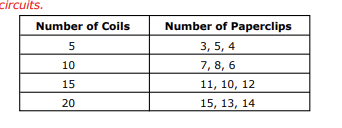

In [ ]:
text_docs = [
    Document(page_content=chunk.text, metadata={"source": f"text_chunk_{i}"})
    for i, chunk in enumerate(text_chunks)
]

In [ ]:
table_docs = [
    Document(
        page_content=chunk.text,
        metadata={
            "source": f"table_chunk_{i}",
            "html": getattr(chunk.metadata, "text_as_html", "No HTML available")
        }
    )
    for i, chunk in enumerate(table_chunks)
]

In [ ]:
all_docs = text_docs + table_docs


In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
db = FAISS.from_documents(all_docs, embedding_model)


In [ ]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
llm = ChatGroq(model="llama3-70b-8192", temperature=0.3)
prompt = ChatPromptTemplate.from_template("""
You are an intelligent assistant. Use the provided context to answer the user's question.
The context may include articles, notes, tables, or reports.
Do not make up information. Be clear, accurate, and concise.

Context:
{context}

Question:
{question}

Answer:
""")

rag_chain = prompt | llm | StrOutputParser()


In [ ]:
from groq import Groq

client = Groq()
models_check = client.models.list()

print("Available models via Groq:") # to pick a better version
for model in models_check.data:
    print("-", model.id)


Available models via Groq:
- meta-llama/llama-4-scout-17b-16e-instruct
- playai-tts-arabic
- meta-llama/llama-4-maverick-17b-128e-instruct
- gemma2-9b-it
- llama-3.3-70b-versatile
- compound-beta-mini
- llama3-70b-8192
- meta-llama/llama-guard-4-12b
- allam-2-7b
- distil-whisper-large-v3-en
- meta-llama/llama-prompt-guard-2-86m
- llama-3.1-8b-instant
- llama3-8b-8192
- qwen/qwen3-32b
- compound-beta
- whisper-large-v3-turbo
- meta-llama/llama-prompt-guard-2-22m
- mistral-saba-24b
- playai-tts
- deepseek-r1-distill-llama-70b
- whisper-large-v3
- qwen-qwq-32b


In [ ]:
while True:
    query = input("👤 You: ")
    if query.lower() in ["exit", "quit"]:
        break
    docs = db.similarity_search(query, k=4)
    context = "\n\n".join([doc.page_content for doc in docs])
    answer = rag_chain.invoke({"context": context, "question": query})
    print(f"\n🤖 GroqBot:\n{answer}\n")


👤 You: Hello what is the document about

🤖 GroqBot:
The document appears to be an example of an afterschool learning activity, specifically a "Pet Survey" designed for Grade 2-3 students, as part of the National Partnership for Quality Afterschool Learning.

👤 You: there are different GR?

🤖 GroqBot:
Yes, there are different Grade Ranges (GR) mentioned in the context. Specifically, the Grade Ranges mentioned are:

* GR 2-3
* GR 5-10
* GR 8-10

👤 You: what info do u have on GR 8-10

🤖 GroqBot:
Based on the provided context, I have information on two examples that correspond to GR 8-10:

1. Example 5: Distance and Time (GR 8-10)
2. Example 3: pH of Substances (GR 5–10) - Note that this example spans a range of grades, including GR 8-10.

👤 You: is it about drops of water vs distance

🤖 GroqBot:
Yes, the experiment is about the relationship between the number of drops of water (representing time) and the distance traveled by the car. The data collected shows how far the car traveled at ea

It worked exceptionally well. The fact that it is able to extract 8-10 and 5-10 and consider 5-10 in table as the grades 8-10 category.

# Now testing images

In [ ]:
from unstructured.partition.pdf import partition_pdf
from unstructured.documents.elements import Table, CompositeElement, Image
from pathlib import Path

# Load your PDF
PDF_FILE = Path("/content/different types of bars.pdf")

# Extract chunks from the PDF
chunks = partition_pdf(
    filename=str(PDF_FILE),
    strategy="hi_res",
    infer_table_structure=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    include_page_breaks=False,
)

In [ ]:
print(f"\nTotal Chunks Extracted: {len(chunks)}\n")
for i, chunk in enumerate(chunks):
    print(f"--- Chunk {i} ---")
    print(f"Type: {type(chunk)}")
    if hasattr(chunk, "text") and chunk.text.strip():
        print(f"Text Sample:\n{chunk.text[:300]}...\n")
    if hasattr(chunk.metadata, "image_base64") and chunk.metadata.image_base64:
        print(" Image found (base64 available)\n")
    if isinstance(chunk, Table):
        print("Table Detected")
        if hasattr(chunk.metadata, "text_as_html"):
            print(" Table has HTML representation\n")


Total Chunks Extracted: 56

--- Chunk 0 ---
Type: <class 'unstructured.documents.elements.Text'>
Text Sample:
Types of Graphs and Their Uses...

--- Chunk 1 ---
Type: <class 'unstructured.documents.elements.NarrativeText'>
Text Sample:
Silvia Valcheva...

--- Chunk 2 ---
Type: <class 'unstructured.documents.elements.NarrativeText'>
Text Sample:
http://intellspot.com/types-graphs-charts...

--- Chunk 3 ---
Type: <class 'unstructured.documents.elements.Image'>
Text Sample:
"| ntellspot...

 Image found (base64 available)

--- Chunk 4 ---
Type: <class 'unstructured.documents.elements.Title'>
Text Sample:
Every graph is a visual representation of data. This article describes five common types of statistical graphs widely used in any science....

--- Chunk 5 ---
Type: <class 'unstructured.documents.elements.Title'>
Text Sample:
1.Line Graph...

--- Chunk 6 ---
Type: <class 'unstructured.documents.elements.NarrativeText'>
Text Sample:
A Line Graph displays data that change. Every Line Graph

Great its detecting both :)

In [ ]:
text_chunks, table_chunks, image_chunks = [], [], []

for chunk in chunks:
    if isinstance(chunk, Table):
        table_chunks.append(chunk)
    elif hasattr(chunk, "text") and chunk.text.strip():
        text_chunks.append(chunk)
    if hasattr(chunk.metadata, "image_base64"):
        image_chunks.append(chunk)


In [ ]:
from transformers import pipeline
from PIL import Image
from io import BytesIO
import base64
# This is just a simple image captioning one I am using for testing
# can later switch more specific ones like -> chart
captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")

def summarize_image_b64(chunk):
    b64 = chunk.metadata.image_base64
    img = Image.open(BytesIO(base64.b64decode(b64))).convert("RGB")
    caption = captioner(img)[0]["generated_text"]
    return caption


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [ ]:
from transformers import pipeline
from PIL import Image
from io import BytesIO
import base64

blip = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")



Device set to use cpu


In [ ]:
def summarize_image_b64_safe(chunk):
    b64 = getattr(chunk.metadata, "image_base64", None)
    if not b64:
        return "No image data available."
    img = Image.open(BytesIO(base64.b64decode(b64))).convert("RGB")
    return captioner(img)[0]["generated_text"]

image_summaries = [summarize_image_b64_safe(c) for c in image_chunks if getattr(c.metadata, "image_base64", None)]


In [ ]:
for i, s in enumerate(image_summaries):
    print(f"\n--- Image Summary {i+1} ---\n{s}")


--- Image Summary 1 ---
the intelspt logo

--- Image Summary 2 ---
an image of a graph with the number of sales items

--- Image Summary 3 ---
a bar chart showing the percentage of the sales price of a product

--- Image Summary 4 ---
types of transportation school

--- Image Summary 5 ---
a bar chart showing the percentage of people who have been diagnosed

--- Image Summary 6 ---
a graph with the same value as a line


works decently well


# Image summaries approach

- Storing summaries of images takes less storage compared to the entire image on vector database - FAISS

In [ ]:
from langchain_core.documents import Document

docs = []
docs += [Document(page_content=c.text, metadata={"type": "text"}) for c in text_chunks]

docs += [Document(page_content=c.metadata.text_as_html, metadata={"type": "table"}) for c in table_chunks]

# store caption but keep full image ref in metadata
for caption, chunk in zip(image_summaries, image_chunks):
    docs.append(Document(
        page_content=caption,
        metadata={"type": "image", "image_base64": chunk.metadata.image_base64}
    ))


In [ ]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
db = FAISS.from_documents(docs, embedding_model)


In [ ]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

groq_llm = ChatGroq(model="llama3-70b-8192", temperature=0.3)

prompt = ChatPromptTemplate.from_template("""
You are a helpful assistant. Use ONLY the context below to answer. Be accurate and concise.

Context:
{context}

Question:
{question}

Answer:
""")

rag_chain = prompt | groq_llm | StrOutputParser()


In [ ]:
from transformers import BlipForConditionalGeneration, BlipProcessor
import torch

# Advanced image reasoning model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
vqa_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-vqa-base").to("cuda" if torch.cuda.is_available() else "cpu")

def answer_image_question(query, image_b64):
    img = Image.open(BytesIO(base64.b64decode(image_b64))).convert("RGB")
    inputs = processor(img, query, return_tensors="pt").to(vqa_model.device)
    out = vqa_model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [ ]:
def answer_question(query: str):
    query_lower = query.lower()
    image_keywords = ["chart", "graph", "figure", "plot", "image", "bar", "line", "pie", "scatter", "visual"]
    results = db.similarity_search(query, k=3)
    if any(k in query_lower for k in image_keywords):
        for r in results:
            if r.metadata.get("type") == "image" and r.metadata.get("image_base64"):
                print("📸 Detected image-related query → Using vision model")
                return answer_image_question(query, r.metadata["image_base64"])
        print("📸 Query mentions image, but no image found in relevant docs — falling back to text.")
    combined_context = "\n\n".join([r.page_content for r in results])
    return rag_chain.invoke({"context": combined_context, "question": query})



In [ ]:
while True:
    user_input = input("👤 You: ")

    if user_input.strip().lower() in ["bye", "quit", "exit"]:
        print("🤖 Goodbye! Have a great day.")
        break

    try:
        response = answer_question(user_input)
        print(f"🤖 {response}\n")
    except Exception as e:
        print(f"Something went wrong: {e}\n")


👤 You: hello what is the document about
🤖 The document appears to be about economics, but the context is limited and there's a mention of the "intelspt logo", which suggests it might be related to a specific company or organization.

👤 You: what types of graphs are there
📸 Query mentions image, but no image found in relevant docs — falling back to text.
🤖 There are five common types of statistical graphs.

👤 You: amazing is there a scatter plot
📸 Query mentions image, but no image found in relevant docs — falling back to text.
🤖 No, the context doesn't mention "amazing" being related to a scatter plot. It only explains the purpose of a scatter plot, which is to show the relationship between two variables.

👤 You: what is the scatter plot about
📸 Query mentions image, but no image found in relevant docs — falling back to text.
🤖 The scatter plot is about showing a relationship between two variables.

👤 You: what variables
🤖 independent and dependent

👤 You: what does the x and y axis sa

this failed at either detecting the image or correlating the image summary to the user prompt

In [ ]:
#Print image metadata for inspection
for i, img_chunk in enumerate(image_chunks):
    print(f"\n Image Chunk {i}")
    print("Type:", type(img_chunk))
    print("Metadata keys:", img_chunk.metadata.__dict__.keys())
    print("Image caption (if summarized):", image_summaries[i] if i < len(image_summaries) else "No caption yet")
    print("Has base64?", "Yes" if img_chunk.metadata.image_base64 else "No")



 Image Chunk 0
Type: <class 'unstructured.documents.elements.Text'>
Metadata keys: dict_keys(['coordinates', 'links', 'last_modified', '_known_field_names', 'filetype', 'languages', 'page_number', 'file_directory', 'filename'])
Image caption (if summarized): the intelspt logo
Has base64? No

 Image Chunk 1
Type: <class 'unstructured.documents.elements.NarrativeText'>
Metadata keys: dict_keys(['detection_class_prob', 'coordinates', 'links', 'last_modified', '_known_field_names', 'filetype', 'languages', 'page_number', 'file_directory', 'filename'])
Image caption (if summarized): an image of a graph with the number of sales items
Has base64? No

 Image Chunk 2
Type: <class 'unstructured.documents.elements.NarrativeText'>
Metadata keys: dict_keys(['detection_class_prob', 'coordinates', 'links', 'last_modified', '_known_field_names', 'filetype', 'languages', 'page_number', 'file_directory', 'filename'])
Image caption (if summarized): a bar chart showing the percentage of the sales price o

In [ ]:
from collections import Counter

chunk_types = Counter([type(chunk).__name__ for chunk in chunks])
print(" Chunk types in PDF:")
for k, v in chunk_types.items():
    print(f"• {k}: {v}")


 Chunk types in PDF:
• Text: 11
• NarrativeText: 22
• Image: 6
• Title: 16
• ListItem: 1


In [ ]:
image_chunks = [chunk for chunk in chunks if isinstance(chunk, Image)]
for i, img in enumerate(image_chunks):
    print(f"\n Image Chunk {i}")
    print(f"Type: {type(img)}")

    if hasattr(img.metadata, "image_base64") and img.metadata.image_base64:
        print(" Has base64 image")
    else:
        print(" No base64 image found")



 Image Chunk 0
Type: <class 'unstructured.documents.elements.Image'>
 Has base64 image

 Image Chunk 1
Type: <class 'unstructured.documents.elements.Image'>
 Has base64 image

 Image Chunk 2
Type: <class 'unstructured.documents.elements.Image'>
 Has base64 image

 Image Chunk 3
Type: <class 'unstructured.documents.elements.Image'>
 Has base64 image

 Image Chunk 4
Type: <class 'unstructured.documents.elements.Image'>
 Has base64 image

 Image Chunk 5
Type: <class 'unstructured.documents.elements.Image'>
 Has base64 image


In [ ]:
valid_images = []
for img in image_chunks:
    b64 = getattr(img.metadata, "image_base64", None)
    if b64:
        valid_images.append((img, b64))

print(f"\n Found {len(valid_images)} images with base64 data.")



 Found 6 images with base64 data.


In [ ]:
blip = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")

def summarize_image_b64(b64):
    img = PILImage.open(BytesIO(base64.b64decode(b64))).convert("RGB")
    return blip(img)[0]["generated_text"]


Device set to use cpu



 Image 1
 BLIP sees:
the intelspt logo


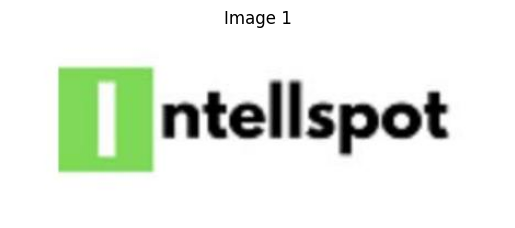


 Image 2
 BLIP sees:
an image of a graph with the number of sales items


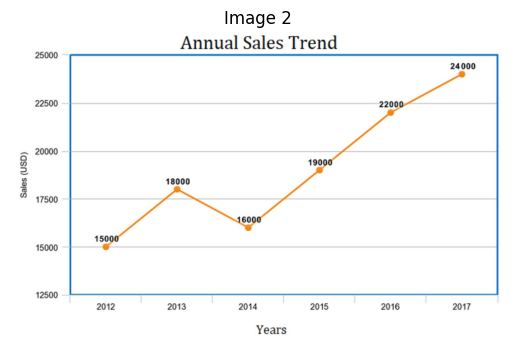


 Image 3
 BLIP sees:
a bar chart showing the percentage of the sales price of a product


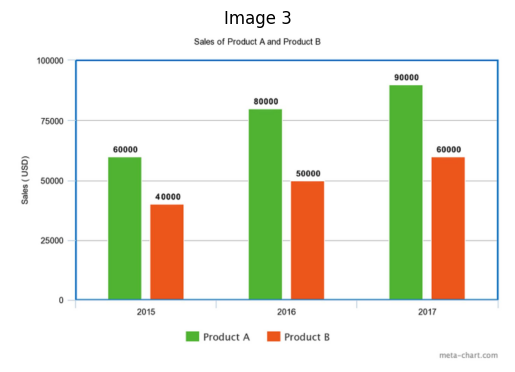


 Image 4
 BLIP sees:
types of transportation school


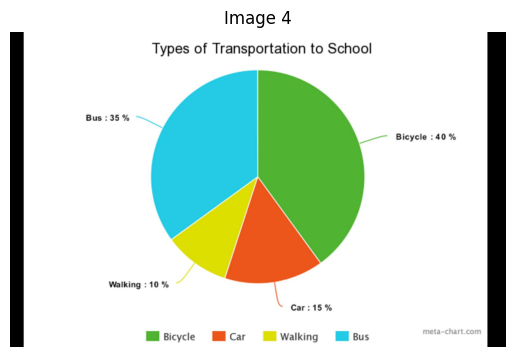


 Image 5
 BLIP sees:
a bar chart showing the percentage of people who have been diagnosed


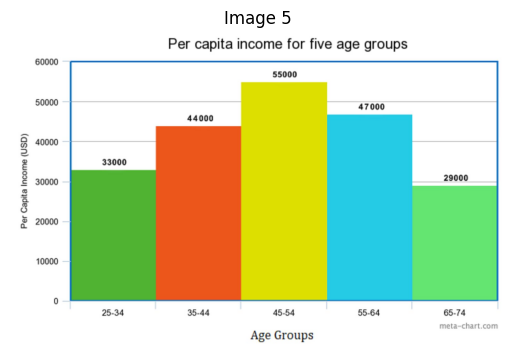


 Image 6
 BLIP sees:
a graph with the same value as a line


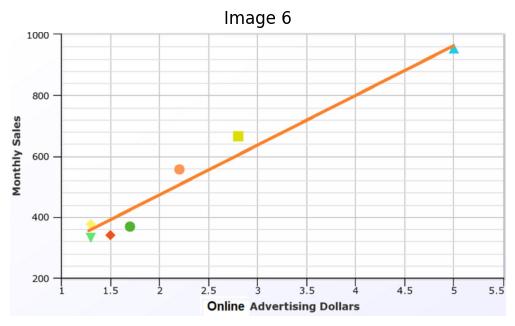

In [ ]:
for i, (chunk, b64) in enumerate(valid_images):
    img = PILImage.open(BytesIO(base64.b64decode(b64))).convert("RGB")

    print(f"\n Image {i+1}")
    print(" BLIP sees:")
    print(blip(img)[0]["generated_text"])  # what BLIP describes

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()


able to detect text 5/6 times


# Enhancing the accuracy of image extraction

- Combining BLIP and pytesseract enhances the accuracy of image extraction particularly for scanned PDFs

- By extracting both the images and the numerical information contained within them, this approach ensures more comprehensive data capture and so  it leads to improved summaries

- Also the extracted textual data can be passed directly to the language model for more precise downstream analysis


🔎 Image 1
📌 Combined Summary:
BLIP: the intelspt logo | OCR: "| ntellspot


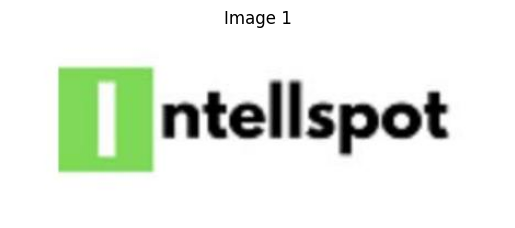


🔎 Image 2
📌 Combined Summary:
BLIP: an image of a graph with the number of sales items | OCR: Sales (USD)

25000

22500

20000

17500

15000

12500

2012

Annual Sales Trend

2013 2014 2015

Years

2016

 

2017


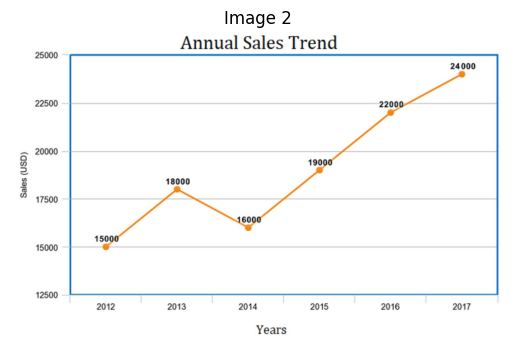


🔎 Image 3
📌 Combined Summary:
BLIP: a bar chart showing the percentage of the sales price of a product | OCR: Sales (USD)

100000

75000

50000

25000

Sales of Product A and Product B

 

 

 

 

 

 

2015

2016

MM ProductA [Hil Product B

 

2017

meta-chart.com


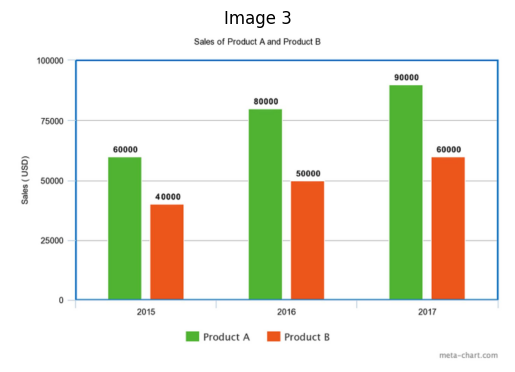


🔎 Image 4
📌 Combined Summary:
BLIP: types of transportation school | OCR: Types of Transportation to School

    

Bus :35 % wy

_—— Bicycle :40 %

Walking : 10 %

Car:15 %

 

M Bicycle EI Car | Walking ga Bus meta-chart.cor


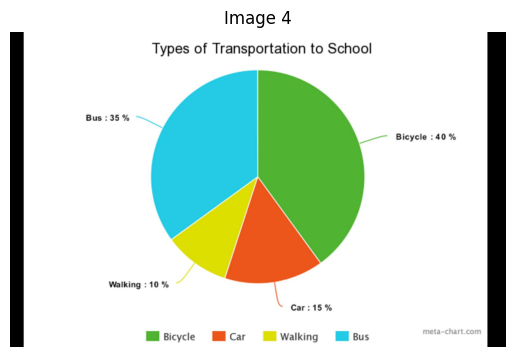


🔎 Image 5
📌 Combined Summary:
BLIP: a bar chart showing the percentage of people who have been diagnosed | OCR: Per Capita Income (USD)

60000

50000

40000

30000

20000

10000

25-34

Per capita income for five age groups

35-44

45.54

Age Groups

55-64

 

65-74

meta-chart.com


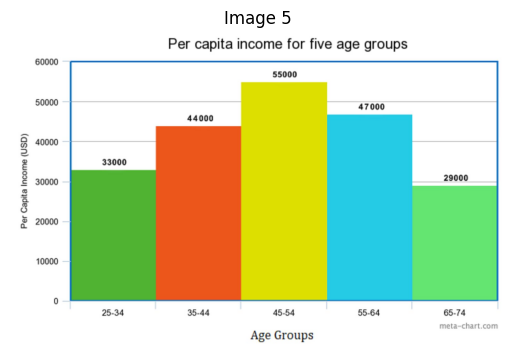


🔎 Image 6
📌 Combined Summary:
BLIP: a graph with the same value as a line | OCR: Monthly Sales

1000

800

600

400

200

1.5

2.5 3 3.5 4
Online Advertising Dollars

 

4.5

5:5


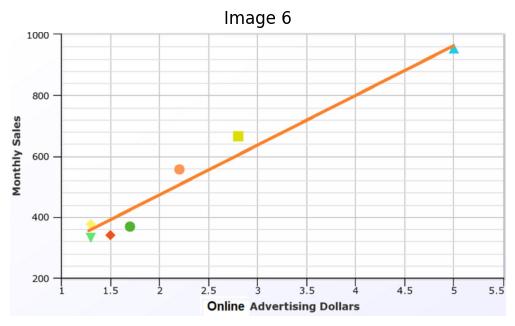

In [ ]:
import pytesseract
import matplotlib.pyplot as plt

def ocr_image_text(img):
    return pytesseract.image_to_string(img)

for i, (chunk, b64) in enumerate(valid_images):
    img = PILImage.open(BytesIO(base64.b64decode(b64))).convert("RGB")

    # Get captions and OCR
    blip_caption = blip(img)[0]["generated_text"]
    ocr_text = ocr_image_text(img)

    # Combine
    combined_summary = f"BLIP: {blip_caption.strip()} | OCR: {ocr_text.strip()}"

    # Show image
    print(f"\n🔎 Image {i+1}")
    print("📌 Combined Summary:")
    print(combined_summary)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()


Graph analysis (bar, pie, scatter, etc.)
Scientific diagrams
Financial charts

In [ ]:
docs.append(Document(
    page_content=combined_summary,
    metadata={"type": "image", "image_base64": b64}
))


# This performed way  better go back to this

In [ ]:
from transformers import pipeline
from PIL import Image
from io import BytesIO
import base64
import pytesseract
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
blip = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")


Device set to use cpu


1. OCR -> extract / axis/ label info
2. detect visual trend keywords
3. caption, OCR_text, trend -> Simply from blip

In [ ]:
def analyze_chart_image_b64(b64_image: str):
    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")

    caption = blip(img)[0]["generated_text"]
    ocr_text = pytesseract.image_to_string(img)
    trend_keywords = ["increasing", "rising", "upward", "growth", "positive trend", "steady rise"]
    found_trend = any(word in caption.lower() or word in ocr_text.lower() for word in trend_keywords)
    print(" BLIP Caption:", caption)
    print(" OCR Text:", ocr_text)
    return {
        "caption": caption,
        "ocr_text": ocr_text,
        "trend_detected": found_trend
    }


In [ ]:
def infer_trend_visually(img):
    gray = img.convert("L").resize((100, 100))
    arr = np.array(gray)

    vertical_sum = arr.sum(axis=0)
    trend = np.polyfit(range(len(vertical_sum)), vertical_sum, 1)[0]

    if trend > 0:
        return "upward trend"
    elif trend < 0:
        return " downward trend"
    else:
        return " flat trend"


In [ ]:
image_base64 = image_chunks[0].metadata.image_base64
result = analyze_chart_image_b64(image_base64)

print("\n Summary of Graph Analysis:")
print(f"Caption: {result['caption']}")
print(f"OCR Extracted: {result['ocr_text'][:200]}...")
print(f" Positive Trend? {' YES' if result['trend_detected'] else ' NO'}")


 BLIP Caption: the intelspt logo
 OCR Text: "| ntellspot


 Summary of Graph Analysis:
Caption: the intelspt logo
OCR Extracted: "| ntellspot
...
 Positive Trend?  NO


In [ ]:
image_base64 = image_chunks[5].metadata.image_base64
result = analyze_chart_image_b64(image_base64)

print("\n Summary of Graph Analysis:")
print(f"Caption: {result['caption']}")
print(f"OCR Extracted: {result['ocr_text'][:200]}...")
print(f" Positive Trend? {' YES' if result['trend_detected'] else ' NO'}")

 BLIP Caption: a graph with the same value as a line
 OCR Text: Monthly Sales

1000

800

600

400

200

1.5

2.5 3 3.5 4
Online Advertising Dollars

 

4.5

5:5


 Summary of Graph Analysis:
Caption: a graph with the same value as a line
OCR Extracted: Monthly Sales

1000

800

600

400

200

1.5

2.5 3 3.5 4
Online Advertising Dollars

 

4.5

5:5
...
 Positive Trend?  NO


Trend detection not working -> as it is a positive trend
- Debugging by identifying what it is reading as graph lines to detect slopes

# Trend detection debugging and Optimisation

In [ ]:
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import base64

In [ ]:
import matplotlib.pyplot as plt

def better_infer_trend_from_image(b64_image, show_visuals=True):

    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    open_cv_image = np.array(img)
    open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)

    print(" Original image loaded.")
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)

    print("Performing Hough Line Detection...")

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=30, maxLineGap=10)

    if lines is None:
        print(" No lines detected.")
        return "Could not detect any significant trend visually."

    slopes = []
    image_with_lines = open_cv_image.copy()
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:
            continue
        slope = (y2 - y1) / (x2 - x1)
        slopes.append(slope)
        print(f" Line {i+1}: ({x1},{y1}) → ({x2},{y2}), Slope = {slope:.2f}")
        if show_visuals:
            cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

    avg_slope = np.mean(slopes)
    print(f"\n Average slope from {len(slopes)} lines: {avg_slope:.3f}")

    if show_visuals:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Original")
        axs[1].imshow(edges, cmap='gray')
        axs[1].set_title("Edges")
        axs[2].imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
        axs[2].set_title("Detected Lines")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    if avg_slope < -0.2:
        return " Visually detected an **upward trend**."
    elif avg_slope > 0.2:
        return " Visually detected a **downward trend**."
    else:
        return " Visually detected a **flat or unclear trend**."

 Original image loaded.
🔍 Performing Hough Line Detection...
 Line 1: (136,776) → (1552,776), Slope = 0.00
 Line 2: (136,772) → (1549,772), Slope = 0.00
 Line 3: (136,7) → (1549,7), Slope = 0.00
 Line 4: (710,396) → (1553,396), Slope = 0.00
 Line 5: (409,548) → (1554,548), Slope = 0.00
 Line 6: (136,392) → (699,392), Slope = 0.00
 Line 7: (136,203) → (1071,203), Slope = 0.00
 Line 8: (473,10) → (1553,10), Slope = 0.00
 Line 9: (335,586) → (1554,586), Slope = 0.00
 Line 10: (466,620) → (1554,620), Slope = 0.00
 Line 11: (343,582) → (1554,582), Slope = 0.00
 Line 12: (159,47) → (314,47), Slope = 0.00
 Line 13: (471,243) → (992,243), Slope = 0.00
 Line 14: (136,200) → (314,200), Slope = 0.00
 Line 15: (774,430) → (1395,430), Slope = 0.00
 Line 16: (1242,166) → (1553,166), Slope = 0.00
 Line 17: (159,277) → (314,277), Slope = 0.00
 Line 18: (1322,87) → (1553,87), Slope = 0.00
 Line 20: (929,356) → (1553,356), Slope = 0.00
 Line 21: (627,467) → (929,467), Slope = 0.00
 Line 23: (1394,281) →

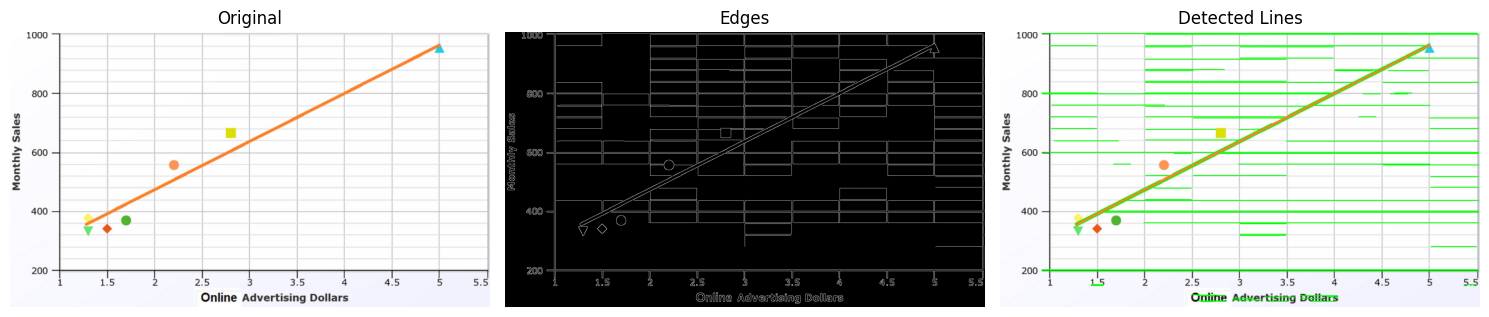

 Final Inference:  Visually detected a **flat or unclear trend**.


In [ ]:
b64 = image_chunks[5].metadata.image_base64
trend = better_infer_trend_from_image(b64, show_visuals=True)
print(" Final Inference:", trend)


- Issue: The current implementation is detecting all grid lines which introduces noise and affects accurate extraction

- Proposed solution: Modify the detection logic to prioritize only the darkest lines, as these are more likely to represent primary boundaries like the table edges rather than internal gridlines -> this  helps reduce false positives and improves the precision of table or layout extraction.

In [ ]:

def detect_main_trend_line(b64_image, show_visuals=True):
    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    open_cv_img = np.array(img)
    open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)

    gray = cv2.cvtColor(open_cv_img, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)

    edges = cv2.Canny(thresh, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80, minLineLength=30, maxLineGap=15)

    if show_visuals:
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(thresh, cmap="gray")
        plt.title("Thresholded (Dark → White)")

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap="gray")
        plt.title("Canny Edges")

    if lines is None:
        print("No lines detected.")
        return "No trend line found."

    best_line = None
    lowest_intensity = 255
    for line in lines:
        x1, y1, x2, y2 = line[0]
        mx, my = (x1 + x2) // 2, (y1 + y2) // 2
        if 0 <= my < gray.shape[0] and 0 <= mx < gray.shape[1]:
            intensity = gray[my, mx]
            if intensity < lowest_intensity:
                lowest_intensity = intensity
                best_line = (x1, y1, x2, y2)

    if best_line is None:
        print("Lines found, but none had valid midpoints.")
        return " No good line to infer trend."

    x1, y1, x2, y2 = best_line
    slope = (y2 - y1) / (x2 - x1 + 1e-6)

    if show_visuals:
        result_img = open_cv_img.copy()
        cv2.line(result_img, (x1, y1), (x2, y2), (0, 0, 255), 3)
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title("Final Detected Trend Line")
        plt.tight_layout()
        plt.show()

    print(f" Detected line: ({x1}, {y1}) → ({x2}, {y2})")
    print(f" Estimated slope: {slope:.4f}")

    if slope < -0.2:
        return "Detected an **upward trend** from darkest line."
    elif slope > 0.2:
        return "Detected a **downward trend** from darkest line."
    else:
        return "Detected a **flat or unclear trend**."


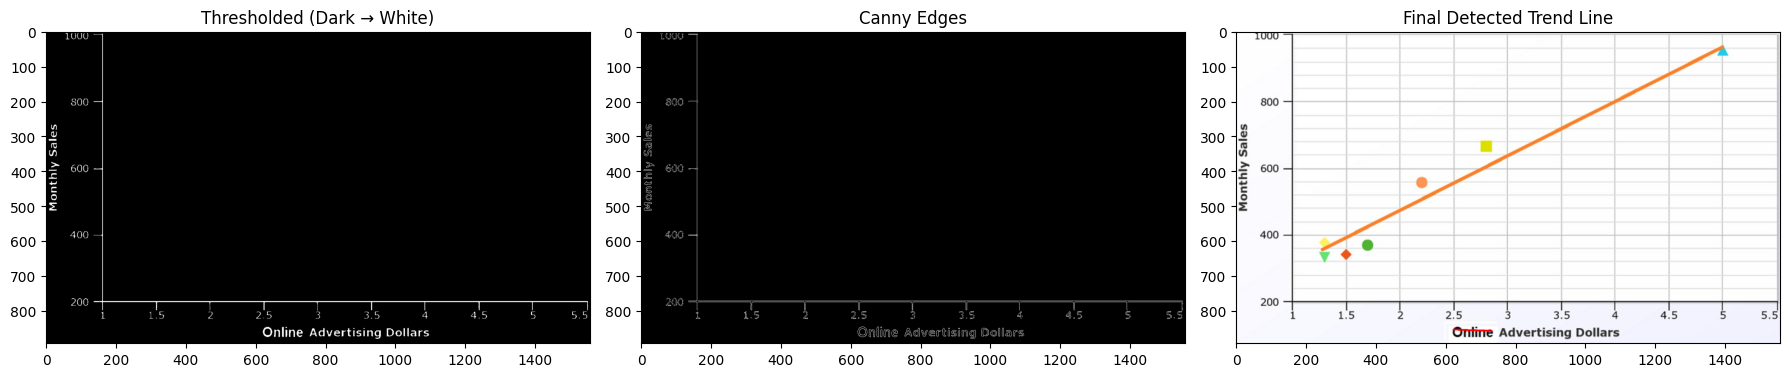

 Detected line: (622, 854) → (733, 858)
 Estimated slope: 0.0360
Detected a **flat or unclear trend**.


In [ ]:
b64 = image_chunks[5].metadata.image_base64
result = detect_main_trend_line(b64)
print(result)


- The line I am trying to detect (orange) might have a high brightness in grayscale, meaning it doesn’t appear “dark enough” to be picked up during thresholding or edge detection.
- but  black grid lines and axis ticks are dark and clean — making them easier for Canny to detect.


In [ ]:
def detect_orange_trend_line(b64_image, show_visuals=True):
    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    open_cv_img = np.array(img)
    open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)

    hsv = cv2.cvtColor(open_cv_img, cv2.COLOR_BGR2HSV)

    lower_orange = np.array([5, 100, 100])
    upper_orange = np.array([25, 255, 255])

    mask = cv2.inRange(hsv, lower_orange, upper_orange)

    orange_only = cv2.bitwise_and(open_cv_img, open_cv_img, mask=mask)
    gray = cv2.cvtColor(orange_only, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=20, maxLineGap=15)

    if show_visuals:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(mask, cmap="gray")
        plt.title("Orange Mask")

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap="gray")
        plt.title("Edges from Masked Area")

    if lines is None:
        print("No orange lines detected.")
        return " Could not detect any trend line in orange."
    best_line = max(lines, key=lambda line: np.linalg.norm([line[0][2] - line[0][0], line[0][3] - line[0][1]]))
    x1, y1, x2, y2 = best_line[0]
    slope = (y2 - y1) / (x2 - x1 + 1e-6)
    if show_visuals:
        result_img = open_cv_img.copy()
        cv2.line(result_img, (x1, y1), (x2, y2), (0, 0, 255), 3)
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title("Detected Orange Trend Line")
        plt.tight_layout()
        plt.show()

    print(f"Orange line: ({x1}, {y1}) → ({x2}, {y2})")
    print(f"Slope: {slope:.4f}")

    if slope < -0.2:
        return "Detected **upward trend** in orange line."
    elif slope > 0.2:
        return "Detected **downward trend** in orange line."
    else:
        return " Detected **flat or unclear trend** in orange line."


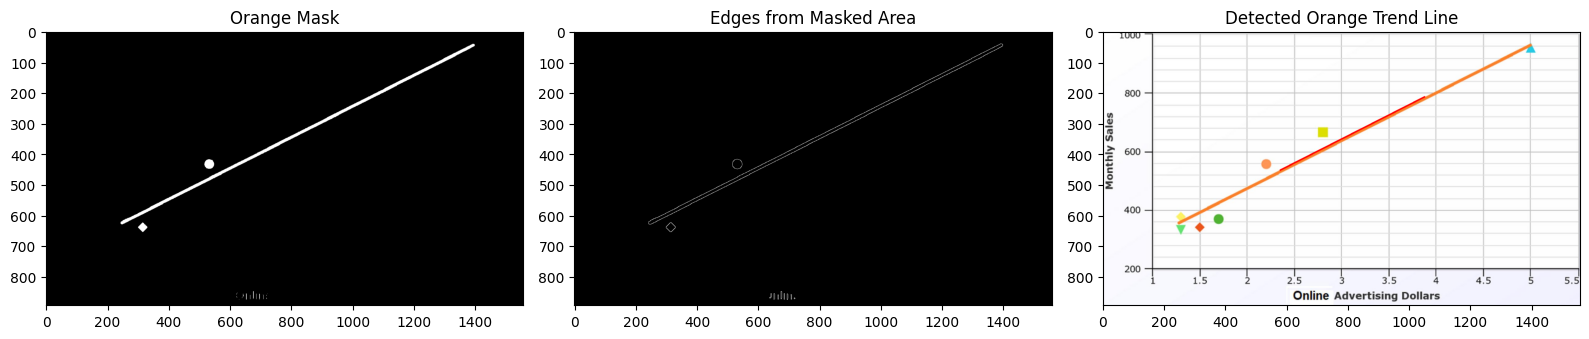

Orange line: (577, 453) → (1048, 214)
Slope: -0.5074


'Detected **upward trend** in orange line.'

In [ ]:
detect_orange_trend_line(image_chunks[5].metadata.image_base64)


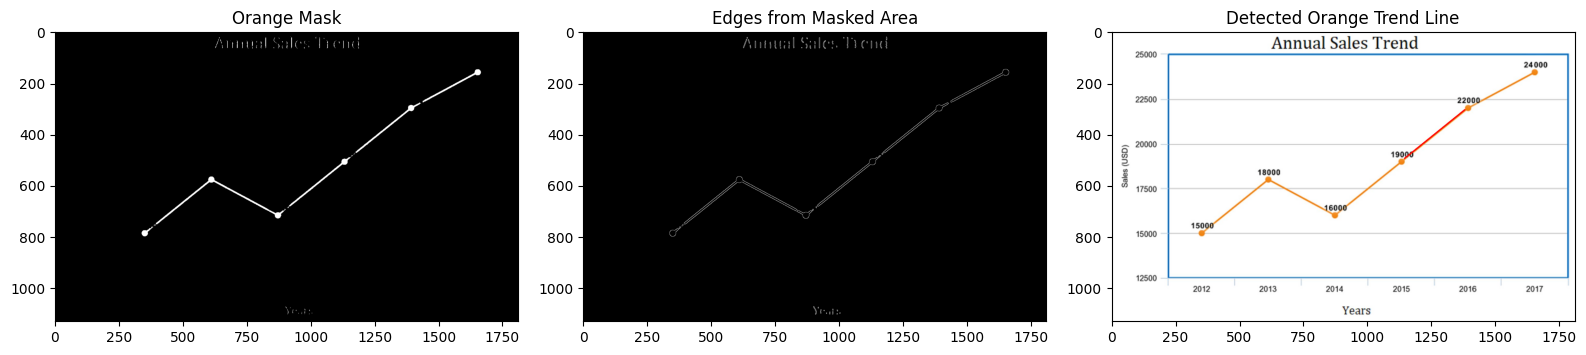

Orange line: (1141, 494) → (1377, 303)
Slope: -0.8093


'Detected **upward trend** in orange line.'

In [ ]:
detect_orange_trend_line(image_chunks[1].metadata.image_base64)


Works now i will generalise it to any coloured line

# Generalising to Any coloured line

In [ ]:
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import base64
import matplotlib.pyplot as plt

def detect_colored_trend_line(b64_image, show_visuals=True):
    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    open_cv_img = np.array(img)
    open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)

    hsv = cv2.cvtColor(open_cv_img, cv2.COLOR_BGR2HSV)

    # This mask is to REMOVE gray/white/black ->low saturation ones like axes,labels, grids
    low_gray = np.array([0, 0, 0])
    high_gray = np.array([180, 70, 255])
    gray_mask = cv2.inRange(hsv, low_gray, high_gray)
    color_mask = cv2.bitwise_not(gray_mask)
    colored_only = cv2.bitwise_and(open_cv_img, open_cv_img, mask=color_mask)
    gray = cv2.cvtColor(colored_only, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=30, maxLineGap=10)

    if show_visuals:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(color_mask, cmap="gray")
        plt.title("Mask: Only Colored Pixels")

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap="gray")
        plt.title("Edges (from Colored Regions)")

    if lines is None:
        print( "No colored lines detected.")
        return " Could not detect any trend visually."

    slopes = []
    result_img = open_cv_img.copy()

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x2 - x1) < 1:
            continue
        slope = (y2 - y1) / (x2 - x1)
        slopes.append(slope)
        if show_visuals:
            cv2.line(result_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    avg_slope = np.mean(slopes)

    if show_visuals:
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title("Detected Colored Lines")
        plt.tight_layout()
        plt.show()

    print(f" Average slope of colored lines: {avg_slope:.4f}")

    if avg_slope < -0.2:
        return " Detected **upward trend** in colored lines."
    elif avg_slope > 0.2:
        return "Detected **downward trend** in colored lines."
    else:
        return "Detected **flat or unclear trend**."


# Final testing



- Use the Hugging face model chart-recognizer to detect whether an image is a bar chart, pie chart, line graph
- BLIP to answer based on image content
- extract any visible text from a chart or image using pytesseract
- Assumption: coloured lines are detected to help tell whether the rend is going upward, downward or flat -> infer get the slope

In [ ]:
# Loading the chart-recognizer classifier
chart_classifier = pipeline(
    "image-classification",
    model="StephanAkkerman/chart-recognizer"
)

def classify_image_b64(b64_image: str):
    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    results = chart_classifier(img)
    return results


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
vqa_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-vqa-base").to("cuda" if torch.cuda.is_available() else "cpu")

def ask_blip_vqa_from_b64(b64_image, question):
    from PIL import Image
    from io import BytesIO
    import base64

    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    inputs = processor(img, question, return_tensors="pt").to(vqa_model.device)
    output = vqa_model.generate(**inputs)
    answer = processor.decode(output[0], skip_special_tokens=True)

    return answer


In [ ]:
def answer_question(query: str):
    results = db.similarity_search(query, k=3)
    if any(k in query.lower() for k in ["chart", "graph", "plot", "figure", "image"]):
        for r in results:
            if r.metadata.get("type") == "image":
                b64 = r.metadata.get("image_base64")
                class_res = classify_image_b64(b64)
                top = class_res[0]
                if top["score"] > 0.7:
                    print(f" Detected a chart with label: {top['label']} ({top['score']*100:.1f}%)")
                    # Using VQA after confirming chart -> Improve chart detetcion accuracy and avoid hallucinations
                    return ask_blip_vqa_from_b64(b64, query)
    combined = "\n\n".join([r.page_content for r in results])
    return rag_chain.invoke({"context": combined, "question": query})


In [ ]:
from transformers import pipeline, BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import pytesseract
import numpy as np
import base64
from io import BytesIO
import cv2
import torch
import matplotlib.pyplot as plt

chart_classifier = pipeline("image-classification", model="StephanAkkerman/chart-recognizer")

def classify_image_b64(b64_image: str):
    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    results = chart_classifier(img)
    return results
def ocr_from_b64(b64_image: str):
    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    text = pytesseract.image_to_string(img)
    return text.strip()

def detect_colored_trend_line(b64_image, show_visuals=True):
    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    open_cv_img = np.array(img)
    open_cv_img = cv2.cvtColor(open_cv_img, cv2.COLOR_RGB2BGR)

    hsv = cv2.cvtColor(open_cv_img, cv2.COLOR_BGR2HSV)
    low_gray = np.array([0, 0, 0])
    high_gray = np.array([180, 70, 255])
    gray_mask = cv2.inRange(hsv, low_gray, high_gray)
    color_mask = cv2.bitwise_not(gray_mask)
    colored_only = cv2.bitwise_and(open_cv_img, open_cv_img, mask=color_mask)

    gray = cv2.cvtColor(colored_only, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=30, maxLineGap=10)

    if show_visuals:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(color_mask, cmap="gray")
        plt.title("Mask: Only Colored Pixels")
        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap="gray")
        plt.title("Edges")

    if lines is None:
        return "No colored lines detected."

    slopes = []
    result_img = open_cv_img.copy()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x2 - x1) < 1:
            continue
        slope = (y2 - y1) / (x2 - x1)
        angle = np.degrees(np.arctan(slope))
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if length < 40 or abs(angle) < 15 or abs(angle) > 75:
            continue

        slopes.append(slope)
        if show_visuals:
            cv2.line(result_img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    if not slopes:
        return "No valid colored trend lines found."

    avg_slope = np.mean(slopes)

    if show_visuals:
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title("Filtered Trend Lines")
        plt.tight_layout()
        plt.show()

    print(f"📏 Avg slope from filtered colored lines: {avg_slope:.3f}")

    if avg_slope < -0.2:
        return "↗️ Upward trend visually detected."
    elif avg_slope > 0.2:
        return "↘️ Downward trend visually detected."
    else:
        return "⏸️ Flat or unclear trend visually."
def better_infer_trend_from_image(b64_image, show_visuals=True):
    img = Image.open(BytesIO(base64.b64decode(b64_image))).convert("RGB")
    open_cv_image = np.array(img)
    open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=30, maxLineGap=10)

    if lines is None:
        return "No lines detected."

    slopes = []
    img_with_lines = open_cv_image.copy()
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:
            continue
        slope = (y2 - y1) / (x2 - x1)
        slopes.append(slope)
        if show_visuals:
            cv2.line(img_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

    avg_slope = np.mean(slopes)
    if show_visuals:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB))
        axs[0].set_title("Original")
        axs[1].imshow(edges, cmap='gray')
        axs[1].set_title("Edges")
        axs[2].imshow(cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB))
        axs[2].set_title("All Lines")


Device set to use cpu


🤖 Hello! Ask me anything about the image.
👤 You: describe

📊 Chart Type: non-chart (52.5%)
🔠 OCR Text Found:
Monthly Sales

1000

800

600

400

200

 

i

25 5 1S q
Online Advertising Dollars

T
45

58



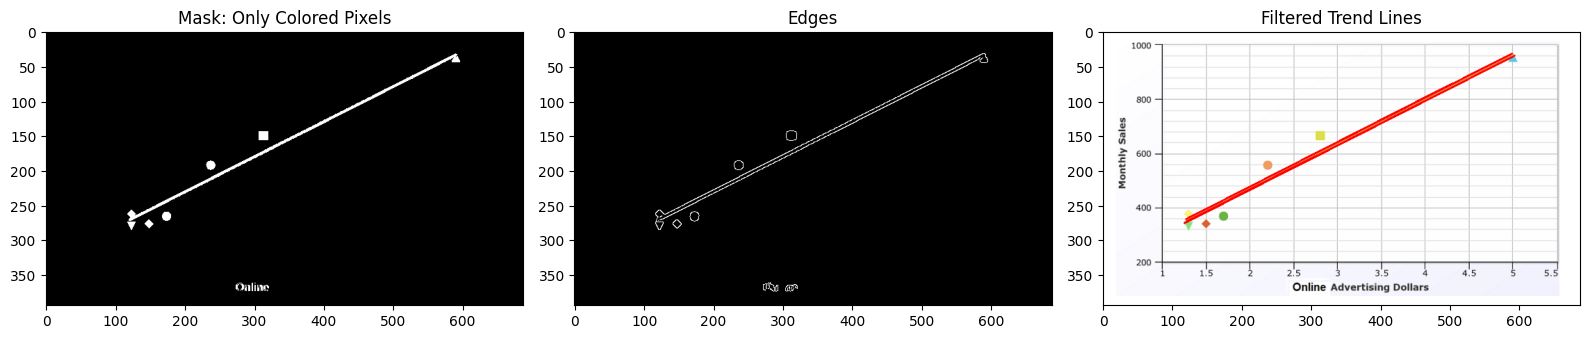

📏 Avg slope from filtered colored lines: -0.508
🎯 Trend (colored lines): ↗️ Upward trend visually detected.
📈 General Trend: None
🤖 VQA Answer: describeer

👤 You: exit
🤖 Bye! 👋


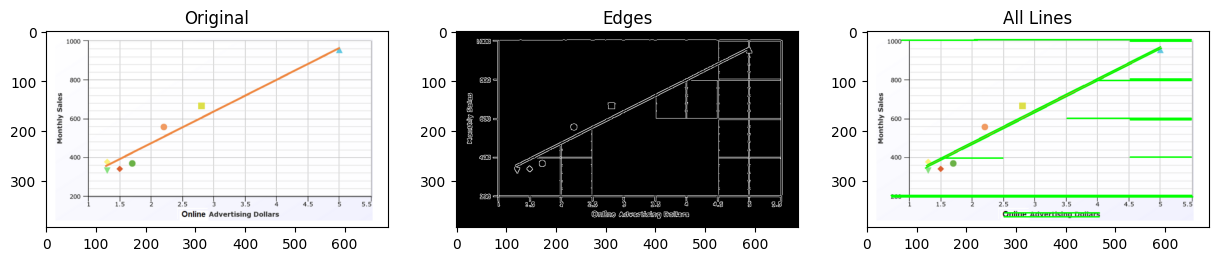

In [ ]:
with open("/content/Screenshot 2025-07-01 at 7.34.02 PM.png", "rb") as f:
    img_bytes = f.read()
    b64_chart = base64.b64encode(img_bytes).decode()

chatbot_on_image(b64_chart)